# Goal

We draw in Boston tide-gauge data and apply a Gaussian Process regression to isolate the long-term trend, seasonal cycle, and other modes of variability.
More info on the Boston Tide Gauge Station is found at: https://tidesandcurrents.noaa.gov/stationhome.html?id=8443970.

Note that the tide gauge data is on the MLLW datum.

# Setup

In [1]:
# import the packages we need for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import os
from datetime import date

# import what we need to check the files
from os import listdir
from os.path import isfile, join

# get the data read function
from tide_gauge_utilities import read_noaa_stn_data

# set up graphics
plt.set_cmap('viridis')

In [2]:
# import the GPflow package
import gpflow
from gp_utilities import normalize, train_data_fit, denormalize
from datetime import datetime

In [3]:
# define the data path
data_path='./sweet_data/raw/'

# get the files in the path
filenames = [f for f in listdir(data_path) if isfile(join(data_path, f))]
nfiles=len(filenames)

# scrape the stn ids
stnids = [s[:7] for s in filenames]

### Load in Metadata

In [4]:
# define the metadata path
md_path='./sweet_data/metadata/metadata_df.pk1'
# read metadata in
metadata = pd.read_pickle(md_path)

# define the location of the date/time dataframe
dtime_loc='./sweet_data/metadata/standard_dtime.pk1'

### Isolate Boston Data

In [5]:
# define the boston stnid
boston_id='8443970'
# get its index
s_want=stnids.index(boston_id)
# load the boston data
df_boston=read_noaa_stn_data(data_path+filenames[s_want],dtime_loc)

/opt/sw/packages/gcc-4.8/python/3.5.2/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Let's look at this dataset in pandas array format:

In [6]:
df_boston

,stn_id,observed,predicted,residual
dtime,,,,
1901-01-01 00:00:00,8443970,NaN,2.845,NaN
1901-01-01 01:00:00,8443970,NaN,2.689,NaN
1901-01-01 02:00:00,8443970,NaN,2.256,NaN
1901-01-01 03:00:00,8443970,NaN,1.653,NaN
1901-01-01 04:00:00,8443970,NaN,0.970,NaN
1901-01-01 05:00:00,8443970,NaN,0.347,NaN
1901-01-01 06:00:00,8443970,NaN,0.048,NaN
1901-01-01 07:00:00,8443970,NaN,0.224,NaN
1901-01-01 08:00:00,8443970,NaN,0.739,NaN


### Calculate and Visualize Monthly Averages

In [7]:
# make a monthly averages dataframe from the observed data
monthly_avg=df_boston['observed'].resample('M').mean()
df_monthly=pd.DataFrame(monthly_avg,index=monthly_avg.index.values)
df_monthly.columns = [boston_id]

In [8]:
# get a numerical grid for datetime
start_date = date(1901, 1, 31)

# assuming your list is named my_date_list
time_grid = df_boston.index.values.astype(float)

In [9]:
time_grid=np.linspace(1901,2018-(1/12),num=(2017-1901+1)*12)

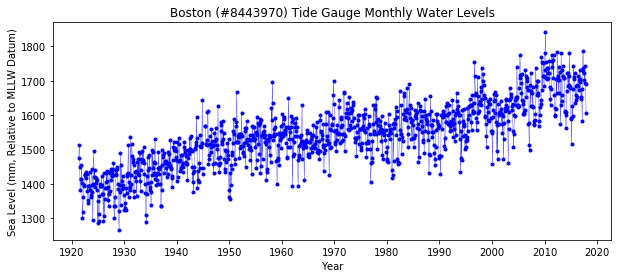

In [10]:
monthly_fig=plt.figure(figsize=(10, 4))
plt.plot(time_grid,df_monthly[boston_id]*1000,lw=0.3,marker='o',markersize=3,color='b',markerfacecolor='b',markeredgecolor='b')
plt.xlabel('Year')
plt.ylabel('Sea Level (mm, Relative to MLLW Datum)')
plt.title('Boston (#8443970) Tide Gauge Monthly Water Levels')
plt.xticks(np.linspace(1920,2020,11))
plt.show()

Compare with the official monthly dataset (https://www.psmsl.org/data/obtaining/stations/235.php):

![title](https://www.psmsl.org/data/obtaining/rlr.monthly.plots/235_high.png)

It clearly looks very similar, but there are some differences too.
Note also that the "datum" is different between these two datasets.

### Calculate simple trend over period

In [11]:
# find the locations which are not NaNs
idx = np.isfinite(df_monthly[boston_id])
# calculate the trends
x=time_grid[np.asarray(idx[:])]
y=df_monthly[boston_id][idx]
z = np.polyfit(x,y,deg=1)

In [15]:
z

array([  2.79239949e-03,  -3.96005759e+00])

In [17]:
# first guess (difference/length of years)*10 years/1 decade*1000mm/1m:
guess_trend=(1.7-1.4)/(2017-1921)*10*1000
print(guess_trend)

# convert units of optimal trend from best fit, from meter/year to mm/decade
z[0]*10*1000

31.250000000000007


27.923994896630802

The first guess trend looks okay, but is not exact. It is an overestimate.

### Calculate Seasonal Cycle

In [18]:
df_monthly['mon'] = df_monthly.index.month
df_seas = df_monthly['1950':'2013'].groupby('mon').aggregate('mean')

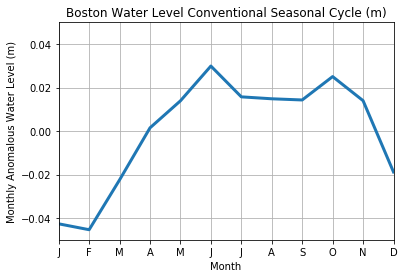

In [19]:
seas_cycle_conventional=plt.figure()
plt.plot(df_seas-np.mean(df_seas),lw=3)
plt.title('Boston Water Level Conventional Seasonal Cycle (m)')
plt.xlabel('Month')
plt.ylabel('Monthly Anomalous Water Level (m)')
plt.xlim([1,12])
plt.ylim([-0.05,0.05])
plt.xticks(np.arange(12)+1, ('J','F','M','A','M','J','J','A','S','O','N','D'))
plt.grid()
plt.show()

# GP Regression

In [20]:
# choose years
start_year=1988
end_year=np.floor(time_grid[-1])
nyears=int(end_year-start_year+1)

In [21]:
nyears

30

In [22]:
# conditon the data and grid, taking data over the years requested
X_train_mediate=np.asarray(time_grid[-12*nyears:],dtype='float64')
Y_train_mediate=np.asarray(df_monthly[boston_id][-12*nyears:],dtype='float64')
# remove nans if we have them
Y_train=Y_train_mediate[np.logical_not(np.isnan(Y_train_mediate))]
X_train=X_train_mediate[np.logical_not(np.isnan(Y_train_mediate))]

In [23]:
np.shape(Y_train)

(360,)

### Define the Sample Grid

In [24]:
#define the sample grid
n_samples=10000
X_sample=np.linspace(start_year,2018-1/12,n_samples).reshape((n_samples,1))

### Plot the Training Data

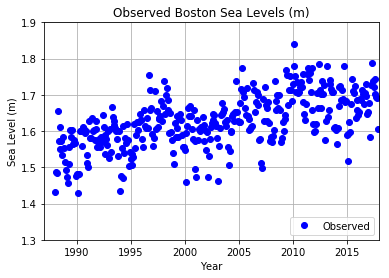

In [25]:
training_ts=plt.figure()
plt.plot(X_train,Y_train,'bo')
plt.xlabel('Year')
plt.ylabel('Sea Level (m)')
plt.xlim([1987,2018])
plt.ylim([1.3,1.9])
#plt.ylim([-0.25,0.25])
plt.title('Observed Boston Sea Levels (m)')
plt.legend(('Observed','GP Mean','2$\sigma$'),loc='lower right')
plt.grid()
plt.show()

### Too Smooth Covariance Structure (RBF)

In [27]:
# start the time
startTime = datetime.now()

# define the training covariance function
k=gpflow.kernels.RBF(1)

# create the model
m = gpflow.models.GPR(X_train.reshape(len(X_train),1), Y_train.reshape(len(X_train),1), kern=k)

#train the model
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

#Print how long it took
print(datetime.now() - startTime)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -493.537443
  Number of iterations: 15
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -493.537443
  Number of iterations: 15
  Number of functions evaluations: 22


0:00:01.298456


In [28]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,4.440536167749865
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.293289378293255
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.002969044101436373


In [29]:
# get model outputs along sample grid
Y_mean,Y_var=m.predict_y(X_sample)

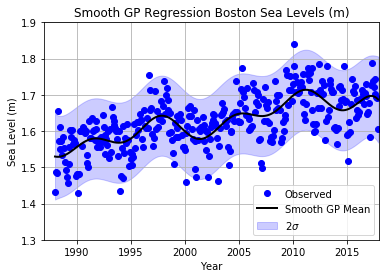

In [30]:
gp_smooth_ts=plt.figure()
plt.plot(X_train,Y_train,'bo')
plt.plot(X_sample,Y_mean,'k',lw=2)
plt.fill_between(X_sample[:,0], Y_mean[:,0] - 2*np.sqrt(Y_var[:,0]), Y_mean[:,0] + 2*np.sqrt(Y_var[:,0]), color='b', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Sea Level (m)')
plt.xlim([1987,2018])
plt.ylim([1.3,1.9])
#plt.ylim([-0.25,0.25])
plt.title('Smooth GP Regression Boston Sea Levels (m)')
plt.legend(('Observed','Smooth GP Mean','2$\sigma$'),loc='best')
plt.grid()
plt.show()

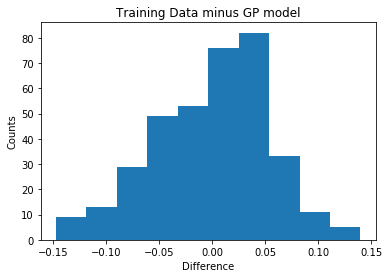

In [31]:
# check to see how well the fit performs
m_fit_range_e=train_data_fit(m,X_train.reshape(len(X_train),1),Y_train.reshape(len(Y_train),1))

### Bob's Covariance Structure

k=@(t1,t2,dt1t2,thetas,dy1y2,fp1fp2) kDP(t1,t2,thetas(1)) + kMat3(dt1t2,thetas(2:3)) + kSIN(dt1t2,[thetas(4) 1 thetas(5)]) +kCONST(thetas(6));

In [32]:
k_bob=gpflow.kernels.Linear(1) \
        + gpflow.kernels.Matern32(1) \
        + gpflow.kernels.Periodic(1) \
        + gpflow.kernels.Constant(1) \

In [33]:
# start the time
startTime = datetime.now()

# create the model
m = gpflow.models.GPR(X_train.reshape(len(X_train),1), Y_train.reshape(len(X_train),1), kern=k_bob)
#m.kern.kernels[2].period=1.0004912144828033
#m.kern.kernels[2].period.trainable=False

#train the model
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

#Print how long it took
print(datetime.now() - startTime)

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -577.906639
  Number of iterations: 33
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -577.906639
  Number of iterations: 33
  Number of functions evaluations: 90


0:00:04.565439


In [34]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,0.8681910989439758
GPR/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,6.195773671973528
GPR/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.019391437297449826
GPR/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,3.1880905900969534
GPR/kern/kernels/2/period,Parameter,None,+ve,True,(),True,1.0004912144828033
GPR/kern/kernels/2/variance,Parameter,None,+ve,True,(),True,0.4753970268745452
GPR/kern/kernels/3/variance,Parameter,None,+ve,True,(),True,0.999603982883255
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.0017912541117148192


## Sample from the GP model

In [35]:
# get model outputs along sample grid
Y_mean,Y_var=m.predict_y(X_sample)

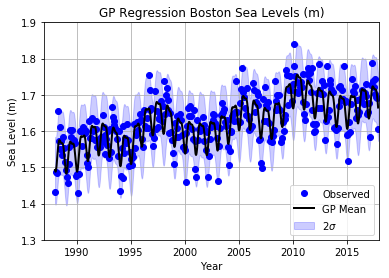

In [36]:
gp_ts=plt.figure()
plt.plot(X_train,Y_train,'bo')
plt.plot(X_sample,Y_mean,'k',lw=2)
plt.fill_between(X_sample[:,0], Y_mean[:,0] - 2*np.sqrt(Y_var[:,0]), Y_mean[:,0] + 2*np.sqrt(Y_var[:,0]), color='b', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Sea Level (m)')
plt.xlim([1987,2018])
plt.ylim([1.3,1.9])
#plt.ylim([-0.25,0.25])
plt.title('GP Regression Boston Sea Levels (m)')
plt.legend(('Observed','GP Mean','2$\sigma$'),loc='lower right')
plt.grid()
plt.show()

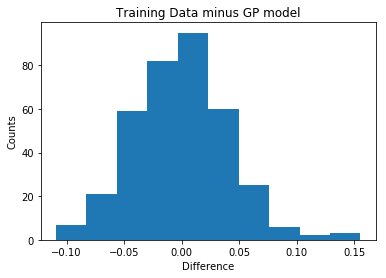

In [37]:
# check to see how well the fit performs
m_fit_range_e=train_data_fit(m,X_train.reshape(len(X_train),1),Y_train.reshape(len(Y_train),1))